In [2]:
from os import remove
from os.path import join
from re import compile, search, findall
from numpy import (
    ndarray,
    array,
    ascontiguousarray,
    zeros,
    empty,
    any,
    diagonal,
    int64,
    float64,
    complex128,
)
from h5py import File
from typing import Tuple
from numpy.linalg import eigh, eigvalsh
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def gaussian(x, mu, sigma, area):
    normalization = area / (sigma * np.sqrt(2 * np.pi))
    return normalization * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def lorentzian(x, mu, gamma, area):
    
    return area / (np.pi) * (gamma) / ((x - mu)**2 + gamma**2)
def convolute_spectral_lines_l(energies, intensities, fwhm, resolution=1000):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    x_min, x_max = min(energies) - 5 * fwhm, max(energies) + 5 * fwhm
    x_values = np.linspace(x_min, x_max, resolution)
    conv_spectrum = np.zeros_like(x_values)

    for energy, intensity in zip(energies, intensities):
        area = intensity  # Assuming intensity is proportional to the desired area
        conv_spectrum += lorentzian(x_values, energy, sigma, area)

    return x_values, conv_spectrum

def convolute_spectral_lines_g(energies, intensities, fwhm, resolution=1000):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    x_min, x_max = min(energies) - 5 * fwhm, max(energies) + 5 * fwhm
    x_values = np.linspace(x_min, x_max, resolution)
    conv_spectrum = np.zeros_like(x_values)

    for energy, intensity in zip(energies, intensities):
        area = intensity  # Assuming intensity is proportional to the desired area
        conv_spectrum += gaussian(x_values, energy, sigma, area)

    return x_values, conv_spectrum
def relative_boltzmann_distribution(x, y, T):

    k = 3.166811563e-6  # Boltzmann constant in a.u./K
    delta_E = y - x   # Energy difference

    return np.exp(-delta_E / (k * T))


def _get_orca_so_blocks_size(
    path: str, orca_file: str
) -> tuple[int, int, int, int]:
    orca_file_path = join(path, orca_file)
    
    with open(orca_file_path, "r") as file:
        content = file.read()

    so_dim_match = search(r"Dim\(SO\)\s+=\s+(\d+)", content)
    if so_dim_match:
        so_dim = int(so_dim_match.group(1))
    else:
        raise ValueError("Dim(SO) not found in the ORCA file.")

    num_blocks = so_dim // 6

    if so_dim % 6 != 0:
        num_blocks += 1

    block_size = ((so_dim + 1) * num_blocks) + 1
    num_of_whole_blocks = so_dim // 6
    remaining_columns = so_dim % 6

    return so_dim, block_size, num_of_whole_blocks, remaining_columns

In [3]:
def _orca_dipole_moment_to_slt(
    path_orca: str,
    inp_orca: str,
    path_out: str,
    hdf5_output: str,
    name: str,
    pt2: bool = False,
) -> None:
    
    hdf5_file = join(path_out, hdf5_output)

    # Retrieve dimensions and block sizes for spin-orbit calculations
    (
        so_dim,
        block_size,
        num_of_whole_blocks,
        remaining_columns,
        
    ) = _get_orca_so_blocks_size(path_orca, inp_orca)

    # Create HDF5 file and ORCA group
    output = File(f"{hdf5_file}.slt", "a")
    orca = output.create_group(str(name))
    orca.attrs["Description"] = (
        f"Group({name}) containing results of relativistic SOC ORCA"
        " calculations - angular momenta and SOC matrix in CI basis"
    )



    matrices = ["TX", "TY", "TZ"]


    for matrix_name in matrices:
        pattern = f"Matrix {matrix_name}\n"
        regex = compile(pattern)

        n=0
        with open(inp_orca, "r") as file:
            if pt2:
                for line in file:
                    if regex.search(line):
                        n+=1
                        if n==2:
                            matrix = empty((so_dim, so_dim), dtype=float64)
                            l = 0
                            for _ in range(num_of_whole_blocks):
                                for _ in range(1):
                                    file.readline()  # Skip a line before each block of 6 columns
                                for i in range(so_dim):
                                    line = file.readline().split()
                                    #print(line)
                                    for j in range(6):
                                        matrix[i, l + j] = float64(line[j+1])
                                        
                                l += 6
                            
                            if remaining_columns > 0:
                                file.readline()  # Skip a line before the remaining columns
                                for i in range(so_dim):
                                    line = file.readline().split()
                                    #print(line)
                                    for j in range(remaining_columns):
                                        matrix[i, l + j] = float64(line[j+1])
                             
                        # Create dataset in HDF5 file and assign the matrix
                        
                            dataset = orca.create_dataset(
                                    f"{matrix_name}", shape=(so_dim, so_dim), dtype=float64
                                )
                            dataset[:, :] = matrix[:, :]
                        
            else:
                n=0
                for line in file:
                    if regex.search(line):
                        n+=1
                        if n==1:
                            matrix = empty((so_dim, so_dim), dtype=float64)
                            l = 0
                            for _ in range(num_of_whole_blocks):
                                for _ in range(1):
                                    file.readline()  # Skip a line before each block of 6 columns
                                for i in range(so_dim):
                                    line = file.readline().split()
                                    #print(line)
                                    for j in range(6):
                                        matrix[i, l + j] = float64(line[j+1])
                                        
                                l += 6
                            
                            if remaining_columns > 0:
                                file.readline()  # Skip a line before the remaining columns
                                for i in range(so_dim):
                                    line = file.readline().split()
                                    #print(line)
                                    for j in range(remaining_columns):
                                        matrix[i, l + j] = float64(line[j+1])
                                     
                                # Create dataset in HDF5 file and assign the matrix
                                
                            dataset = orca.create_dataset(
                                    f"{matrix_name}", shape=(so_dim, so_dim), dtype=float64
                                )
                            dataset[:, :] = matrix[:, :]   


    regex = compile("SOC MATRIX \(A\.U\.\)\n")
    n=0
    with open(inp_orca, "r") as file:
        if pt2:
            for line in file:
                if regex.search(line):
                    n+=1
                    if n==2:
                        for _ in range(3):
                            file.readline()
            
                        matrix_real = empty((so_dim, so_dim), dtype=float64)
                        l = 0
                        for _ in range(num_of_whole_blocks):
                            file.readline()  # Skip a line before each block of 6 columns
                            for i in range(so_dim):
                                line = file.readline()
                                elements = findall(r'[-+]?\d*\.\d+', line)
                                for j in range(6):       
                                    matrix_real[i, l + j] = float64(elements[j])
                            l += 6
                            
                        if remaining_columns > 0:
                            file.readline()  # Skip a line before the remaining columns
                            for i in range(so_dim):
                                line = file.readline()
                                elements = findall(r'[-+]?\d*\.\d+', line)
                                for j in range(remaining_columns):
                                    matrix_real[i, l + j] = float64(elements[j])   
                                
                        
                        for _ in range(2):
                            file.readline()  # Skip 2 lines separating real and imaginary part
                    
                        matrix_imag = empty((so_dim, so_dim), dtype=float64)
                        l = 0
                        for _ in range(num_of_whole_blocks):
                            file.readline()  # Skip a line before each block of 6 columns
                            for i in range(so_dim):
                                line = file.readline()
                                elements = findall(r'[-+]?\d*\.\d+', line)
                                for j in range(6):       
                                    matrix_imag[i, l + j] = float64(elements[j])
                            l += 6
                            
                        if remaining_columns > 0:
                            file.readline()  # Skip a line before the remaining columns
                            for i in range(so_dim):
                                line = file.readline()
                                elements = findall(r'[-+]?\d*\.\d+', line)
                                for j in range(remaining_columns):
                                    matrix_imag[i, l + j] = float64(elements[j])
    
    
    
        else:
            n=0
            for line in file:
                if regex.search(line):
                    n+=1
                    if n==1:
                        for _ in range(3):
                            file.readline()  # Skip the first 3 lines
            
                        matrix_real = empty((so_dim, so_dim), dtype=float64)
                        l = 0
                        for _ in range(num_of_whole_blocks):
                            file.readline()  # Skip a line before each block of 6 columns
                            for i in range(so_dim):
                                line = file.readline()
                                elements = findall(r'[-+]?\d*\.\d+', line)
                                for j in range(6):       
                                    matrix_real[i, l + j] = float64(elements[j])
                            l += 6
                            
                        if remaining_columns > 0:
                            file.readline()  # Skip a line before the remaining columns
                            for i in range(so_dim):
                                line = file.readline()
                                elements = findall(r'[-+]?\d*\.\d+', line)
                                for j in range(remaining_columns):
                                    matrix_real[i, l + j] = float64(elements[j])   
                                
                        
                        for _ in range(2):
                            file.readline()  # Skip 2 lines separating real and imaginary part
                    
                        matrix_imag = empty((so_dim, so_dim), dtype=float64)
                        l = 0
                        for _ in range(num_of_whole_blocks):
                            file.readline()  # Skip a line before each block of 6 columns
                            for i in range(so_dim):
                                line = file.readline()
                                elements = findall(r'[-+]?\d*\.\d+', line)
                                for j in range(6):       
                                    matrix_imag[i, l + j] = float64(elements[j])
                            l += 6
                            
                        if remaining_columns > 0:
                            file.readline()  # Skip a line before the remaining columns
                            for i in range(so_dim):
                                line = file.readline()
                                elements = findall(r'[-+]?\d*\.\d+', line)
                                for j in range(remaining_columns):
                                    matrix_imag[i, l + j] = float64(elements[j])
            
            
            
    dip_mom = zeros((3, so_dim, so_dim), dtype=float64)
    soc_mat = matrix_real[:]+1j*matrix_imag[:]
    dip_mom[0][:] = output[str(name)]["TX"][:]
    dip_mom[1][:] = output[str(name)]["TY"][:]
    dip_mom[2][:] = output[str(name)]["TZ"][:]
    soc_energies, eigenvectors = eigh(soc_mat)
    dip_mom_soc = (eigenvectors.conj().T @ dip_mom @ eigenvectors)        
    
    return soc_energies,dip_mom_soc
        
    
    
    

<>:108: SyntaxWarning: invalid escape sequence '\('
<>:108: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_3409427/2611564406.py:108: SyntaxWarning: invalid escape sequence '\('
  regex = compile("SOC MATRIX \(A\.U\.\)\n")


In [5]:
from threadpoolctl import threadpool_limits
with threadpool_limits(4):
    soc_energies,dip_mom_soc=_orca_dipole_moment_to_slt('.','Eu_bpdo_nevpt2_final.out','.','Eu','6',True)

In [26]:
emmision

22382.072610821007

[551.78189545 562.96767512 563.0110037  565.25346039 582.50707114
 582.59467006 584.80141377 589.50406226 592.6565466  617.45556607
 617.82182728 618.27276699 619.22770896 619.55341821 620.86388413
 624.20998799 648.15271703 657.91125024 658.95561322 660.73989416
 664.36165801 665.67145816 665.92941161 666.24679654 670.04813601
 705.4146652  705.45736534 708.87462065 713.00797099 714.61194203
 715.03227693 717.97423629 718.3023788  720.39875054 721.35057202
 721.69368897 772.87097106 772.95514379 773.34732171 773.40102668
 776.38311449 778.35187425 780.79995704 780.90176757 782.30379124
 783.46279235 783.57655957 790.58705025 790.60290613]
[551.78189545 562.96767512 563.0110037  565.25346039 582.50707114
 582.59467006 584.80141377 589.50406226 592.6565466  617.45556607
 617.82182728 618.27276699 619.22770896 619.55341821 620.86388413
 624.20998799 648.15271703 657.91125024 658.95561322 660.73989416
 664.36165801 665.67145816 665.92941161 666.24679654 670.04813601
 705.4146652  705.4573

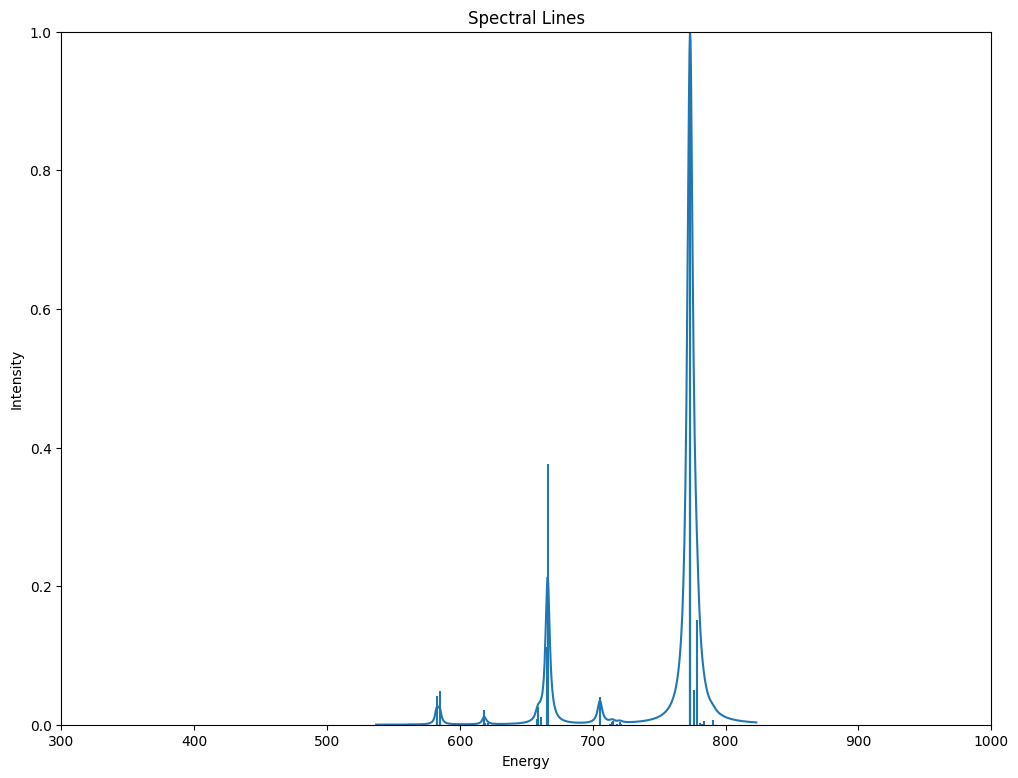

In [10]:
import numpy as np

F =[[49]]

temperatures = np.linspace(10,10, 1)
fwhm = 100
normalize = 1
resolution = 1000
sum_spectra = np.zeros((resolution, ), dtype=np.float64)


fig, axs = plt.subplots(1, 1, figsize=(12, 9))

energies = soc_energies[:]
dipmom=dip_mom_soc[:]
energies = (energies - energies[0])

for index, F_emissive in enumerate(F):
    for T in temperatures:    
        intensities = np.zeros((len(F_emissive),F[0][0]), dtype = np.float64)
        emission_energies_cm = np.zeros((len(F_emissive), F[0][0]), dtype = np.float64)
        for l, level in enumerate(F_emissive):
            for i in range(F[0][0]):
                for k in range(3):
                    intensities[l,i] += relative_boltzmann_distribution(energies[F_emissive[0]], energies[level], T) * 2/3 * np.abs(dipmom[k, i, level])**2 * (energies[level] - energies[i])
                    emission_energies_cm[l,i] = ((energies[level] - energies[i]) * 219474.6)
        intensities = intensities.flatten()
        emission_energies_cm = emission_energies_cm.flatten()
    
        intensities = intensities/max(intensities)
        
        emission_energies_nm = 1e7/emission_energies_cm
        print(emission_energies_nm[:])
        energy_x_cm, spectrum = convolute_spectral_lines_l(emission_energies_cm, intensities, fwhm, resolution)
        spectrum = spectrum/max(spectrum) 
        sum_spectra += spectrum
        energy_x_nm = 1e7/energy_x_cm
      
        
        
    
        
    
axs.vlines(x=emission_energies_nm, ymin=0, ymax=intensities, label="T")
axs.plot(energy_x_nm, spectrum, label=f'{T}')


        


axs.set_xlabel('Energy')
axs.set_ylabel('Intensity')
axs.set_title('Spectral Lines')
axs.set_xlim([300, 1000])
axs.set_ylim([0,normalize])

#df=pd.DataFrame({'x':energy_x_nm,'sp':spectrum})
#df2=pd.DataFrame({'en':emission_energies_nm,'int':intensities})
#df.to_csv('Nd_CN_pt2_spectrum_em')
#df2.to_csv('Nd_CN_pt2_int_em')
print(emission_energies_nm)

In [66]:
import pandas as pd  

df = pd.read_csv('Eu_int_scaled.csv',sep=';')        

intensities=df.iloc[:,1].tolist()
emission_energies=df.iloc[:,0].tolist()

emission_energies_cm=[]
for i in emission_energies:
    emission_energies_cm.append(1e7/i)

In [73]:
intensities

[0.09114,
 0.00309,
 0.02029,
 0.82082,
 0.06811,
 0.96233,
 8.50422e-09,
 2.81249e-09,
 1.92151e-05,
 0.00341,
 0.04357,
 0.00508,
 0.000576848,
 0.00414,
 3.06547e-09,
 4.7157e-09,
 0.00305,
 0.01024,
 0.00421,
 3.46625e-09,
 0.04505,
 0.00606,
 0.15033,
 1.87502e-10]

In [74]:
emission_energies_cm=[]
for i in emission_energies:
    emission_energies_cm.append(1e7/i)
    

In [78]:
emission_energies_cm

[16855.229774116153,
 16853.998864040477,
 16790.539994847994,
 16317.817031156928,
 16315.48482923406,
 16256.953241149582,
 16133.610560390314,
 16051.968569282424,
 15437.445410298507,
 15428.721827751804,
 15417.99486910716,
 15395.327927489729,
 15387.611944492206,
 15356.645499271264,
 15278.138745025266,
 14738.986115757167,
 14529.9999091875,
 14507.984694250243,
 14470.52584689874,
 14395.082777915859,
 14367.992388872128,
 14362.669262441457,
 14356.124925850616,
 14278.205173639108]

In [83]:
energie=[]
inten=[]
with open('Eu_int.txt','r') as f:
    for line in f:
        liczby1=[]
        liczby=line.split()
        for i in liczby:
            liczby1.append((i.replace(',','.')))
        
        energie.append(float(liczby1[0]))
        inten.append(float(liczby1[1]))

energie

[582.1019,
 593.28767,
 593.331,
 595.57346,
 612.82707,
 612.91467,
 615.12141,
 619.82406,
 622.97655,
 647.77557,
 648.14183,
 648.59277,
 649.54771,
 649.87342,
 651.18388,
 654.52999,
 678.47272,
 688.23125,
 689.27561,
 691.05989,
 694.68166,
 695.99146,
 696.24941,
 696.5668,
 700.36814]

In [84]:

energy,spectrum=convolute_spectral_lines_l(energie,inten,1,20000)
spectrum = spectrum/max(spectrum)


In [86]:
energy

array([577.1019    , 577.10831363, 577.11472727, ..., 705.35531273,
       705.36172637, 705.36814   ])

In [87]:
df=pd.DataFrame(spectrum)
df.to_csv('spectrum_Eu_bpdo')
df2=pd.DataFrame(energy)
df2.to_csv('energy_Eu_bpdo')